# Predict ddG

In [8]:
from spurs.inference import get_SPURS, parse_pdb, get_SPURS_from_hub
# ~ 10s
model, cfg = get_SPURS_from_hub()
pdb_name = '1qlh'
pdb_path = '../data/enzyme/1qlh.pdb'
chain = 'A'
pdb = parse_pdb(pdb_path, pdb_name, chain, cfg)
# ~ 1s
ddg = model(pdb,return_logist=True).cpu().detach()

# ESM Score

In [9]:
import esm
import torch
from spurs.functional_site_annotation import get_wt_aa_logit_differences

ckpt = '../data/checkpoints/esm1v_t33_650M_UR90S_1/esm1v_t33_650M_UR90S_1.pt'
model, alphabet = esm.pretrained.load_model_and_alphabet_local(ckpt)
batch_converter = alphabet.get_batch_converter()
model.eval()  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/nethome/zli3161/DATA-nash/miniconda3/envs/spurs/lib/python3.7/site-packages/esm/pretrained.py:216: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  "Regression weights not found, predicting contacts will not produce correct results."


In [10]:
mut_index = list(range(2,376))
'''
 mut_idx here is how the original_sequence aligned with the pdb['seq]
 for example, the original_sequence here is 'MSTAGKVIK...'
 and the pdb['seq'] is 'STAGKVIKCK...'
 so here original_sequence[2-1:376-1] shoudl align with pdb['seq']
'''


original_sequence =  'MSTAGKVIKCKAAVLWEEKKPFSIEEVEVAPPKAHEVRIKMVATGICRSDDHVVSGTLVTPLPVIAGHEAAGIVESIGEGVTTVRPGDKVIPLFTPQCGKCRVCKHPEGNFCLKNDLSMPRGTMQDGTSRFTCRGKPIHHFLGTSTFSQYTVVDEISVAKIDAASPLEKVCLIGCGFSTGYGSAVKVAKVTQGSTCAVFGLGGVGLSVIMGCKAAGAARIIGVDINKDKFAKAKEVGATECVNPQDYKKPIQEVLTEMSNGGVDFSFEVIGRLDTMVTALSCCQEAYGVSVIVGVPPDSQNLSMNPMLLLSGRTWKGAIFGGFKSKDSVPKLVADFMAKKFALDPLITHVLPFEKINEGFDLLRSGESIRTILTF'
mask_results = get_wt_aa_logit_differences(original_sequence,mut_index,batch_converter,model,device,alphabet).cpu().detach()

# Regression using sigmoid

In [11]:
from spurs.functional_site_annotation import get_sigmoid_results

result = get_sigmoid_results(mask_results,ddg)

torch.Size([7480]) torch.Size([7480]) torch.Size([7480])


# Functional Sites

In [13]:
# calculate the function score, not necessary for the next step
import numpy as np
from spurs.functional_site_annotation import sigmoid_function
arr = (result[0].numpy()-sigmoid_function(result[1].numpy(), *result[-1])).reshape(-1,20).sum(-1)
    # normalize the data
data = arr
mean = np.nanmean(data)
std_dev = np.nanstd(data)
z_scores = (data - mean) / std_dev


min_z = np.nanmin(z_scores)
max_z = np.nanmax(z_scores)
function_score = 2 * (z_scores - min_z) / (max_z - min_z) - 1

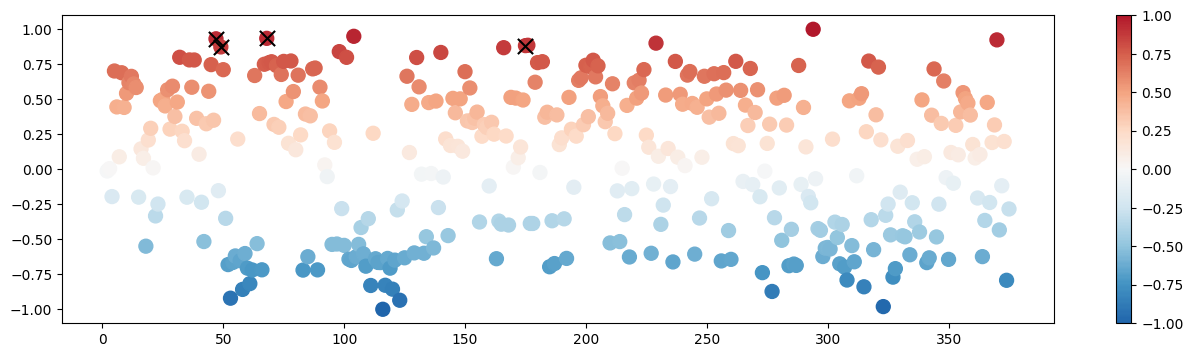

array([-0.01223314,  0.00452507, -0.19502294,  0.70201933,  0.4453659 ,
        0.08906341,  0.6894417 ,  0.44176555,  0.54231036,  0.618484  ,
        0.6637119 ,  0.60936415,  0.58403623, -0.19907838,  0.14574718,
        0.07855487, -0.5493716 ,  0.20916462,  0.2927885 ,  0.00996327,
       -0.3332551 , -0.24840784,  0.4901501 ,  0.499462  ,  0.45243788,
        0.56801105,  0.28679967,  0.59353495,  0.37739456,  0.47996712,
        0.80001795,  0.27157462,  0.20412695, -0.19954282,  0.78114176,
        0.5859326 ,  0.7806829 ,  0.36385715,  0.10751975, -0.235479  ,
       -0.51614815,  0.32507515,  0.55714464,  0.7474394 ,  0.35047543,
        0.9319272 , -0.15293711,  0.8738978 ,  0.7114378 , -0.350353  ,
       -0.6808026 , -0.92082167, -0.6654612 , -0.61899686,  0.21572375,
       -0.6533    , -0.8580947 , -0.60186344, -0.70636964, -0.8168428 ,
       -0.71926856,  0.6697086 , -0.5310782 ,  0.39805806, -0.7181377 ,
        0.75024164,  0.9352467 ,  0.7620996 ,  0.76809835,  0.32

In [16]:
from spurs.functional_site_annotation import plot_sigmoid_results
shift = 2
vcenter = 0
# ground truth label
highlight_positions =[49] +[47,68,175]
plot_sigmoid_results(result,shift,vcenter,highlight_positions)